## DEMO

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

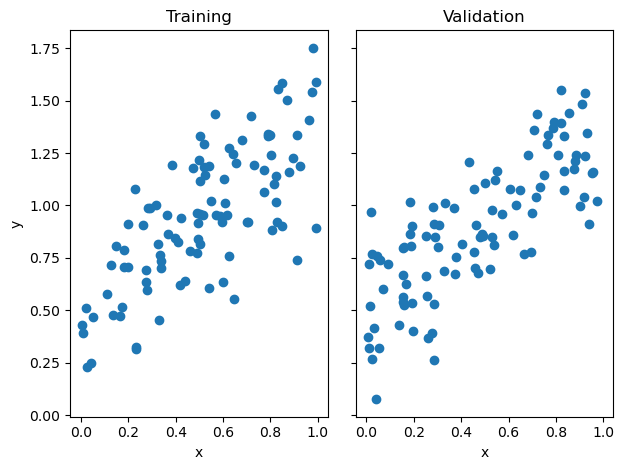

In [2]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

In [3]:
from linear_regression import LinearRegression

LR = LinearRegression()
LR.fit_analytic(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score = {LR.score(pad(X_train), y_train).round(4)}")
print(f"Validation score = {LR.score(pad(X_val), y_val).round(4)}")

Training score = 0.5453
Validation score = 0.6153


In [4]:
LR.w

array([0.89997685, 0.48451945])

In [5]:
LR2 = LinearRegression()

LR2.fit_gradient(X_train, y_train, alpha = 0.01, max_iter = 1e2)

In [6]:
LR2.w

array([0.89895501, 0.48507717])

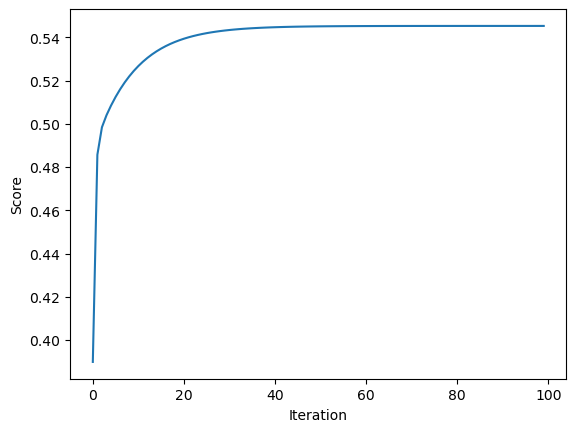

In [7]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")

## Experiments

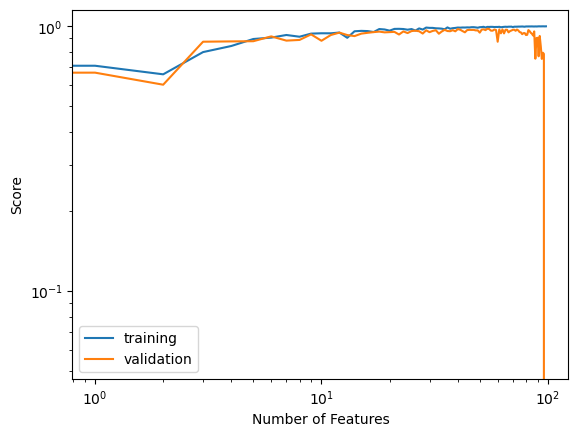

In [14]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR = LinearRegression()
    LR.fit_analytic(X_train, y_train)
    training_scores.append(LR.score(pad(X_train), y_train))
    validation_scores.append(LR.score(pad(X_val), y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

## LASSO 

In [9]:
from sklearn.linear_model import Lasso
L = Lasso(alpha = 0.001)
p_features = n_train - 1
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
L.fit(X_train, y_train)

L.score(X_val, y_val)

0.7548622009585426

## LASSO 

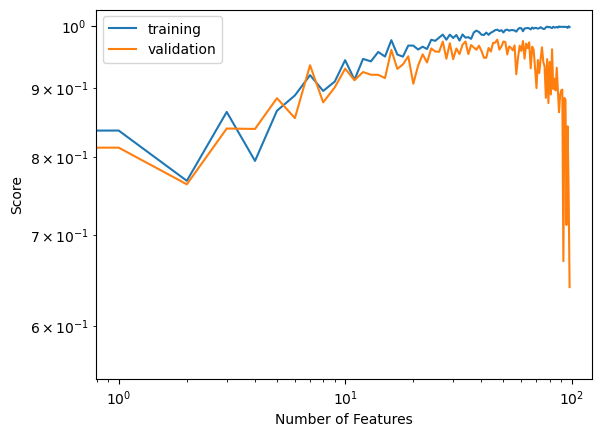

In [10]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.0009)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

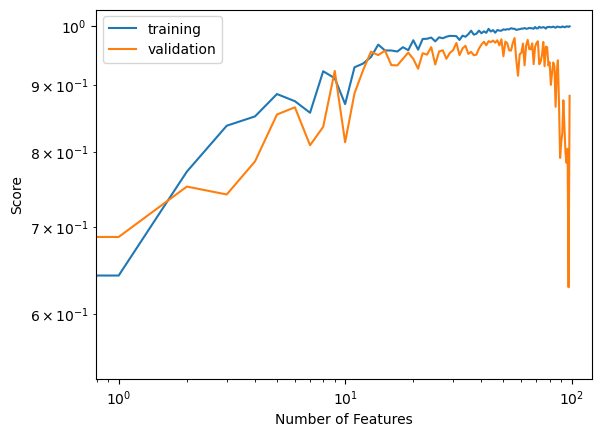

In [11]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.001)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

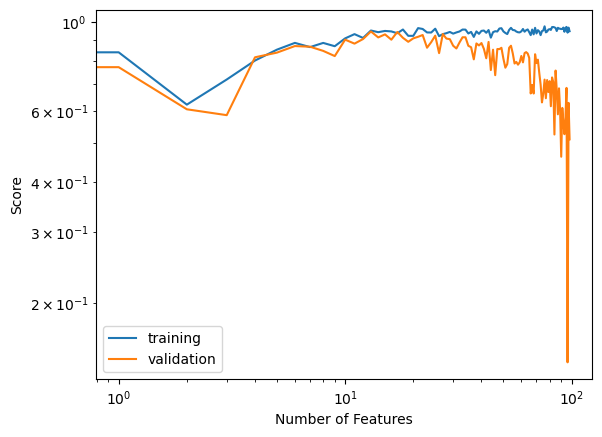

In [12]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.01)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

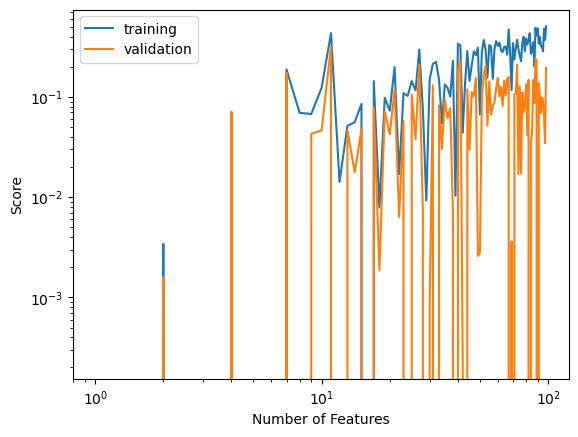

In [13]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.1)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")